In [1]:
%reload_ext autoreload
%autoreload 2

from pathlib import Path
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
from typing import Union, Any, Dict
import ipywidgets as widgets
from IPython.display import display, clear_output
from ipywidgets import interact, interactive
from tqdm.notebook import tqdm
from uncertainty_estimation import tiffread_utils, fft_funcs, glen_funcs
import itertools


# currently unused
# import itertools
# import pickle
# import random


In [3]:
list1 = ['BlueTopo_US5NH1AH_20220505.tiff', "Rough_FL.tif", "Rough_Slopey.tif", "Flat_LA.tif", "Slopey_MA.tif"]
blue = ['BlueTopo_US5NH1AH_20220505.tiff', 'BlueTopo_BH5245GN_20230804.tiff']
rough = ["Rough_FL.tif", "Rough_FL_2.tif", "Rough_FL_3.tif"]
rs = ["Rough_Slopey.tif", "Rough_Slopey_2.tif"]
flat = ["Flat_LA.tif", "Flat_LA_2.tif", "Flat_LA_3.tif"]
slopey = ["Slopey_MA.tif", "Slopey_MA_2.tif"]
giga_list = [list1, blue, rough, rs, flat, slopey]
all_files = list(itertools.chain(*giga_list))

# define simulation constants
window_multiples = [1, 2, 4]
selection = 'half'
max_multiple = np.max(window_multiples)

linespacing_meters =  [32, 64, 128, 256, 512, 1024]
fft_methods = ['amplitude', 'psd', 'spectrum']
selection = ['half', 'index']
window = ['hann']

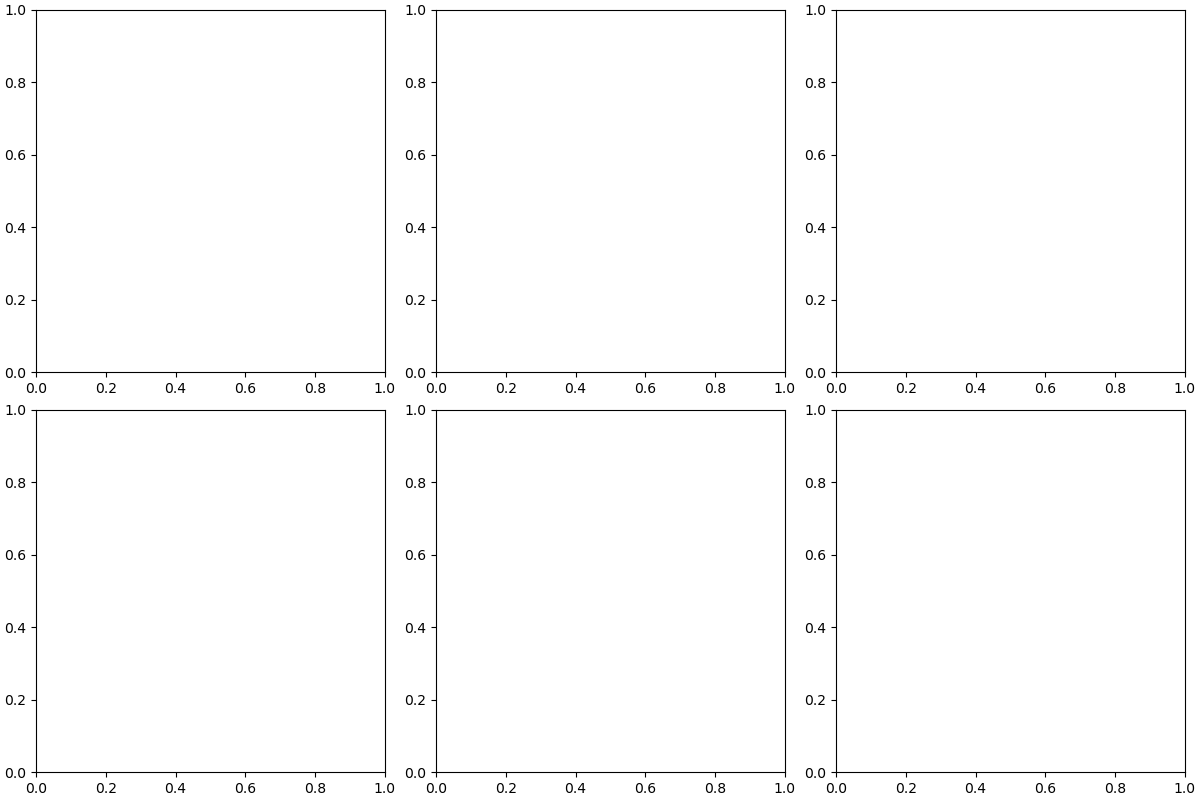

In [4]:
filename_selector = widgets.Dropdown(
    options=list1,
    value=None,
    description='Surface:',
    disabled=False,
)

linespacing_selector = widgets.Dropdown(
    options=linespacing_meters,
    description='Linespacing (m)',
    style={'description_width': 'initial'},
    disabled=True,
    value=None,
    continuous_update=False,
    orientation='horizontal',
    readout=True
)

fft_selector = widgets.Dropdown(
    options=fft_methods,
    description='Uncertainty Method:',
    style={'description_width': 'initial'},
    disabled=False,
    value=None,
    positioning='top'
)

window_size_selector = widgets.SelectionSlider(
    options=window_multiples,
    description='Multiple',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True
)

run_button = widgets.Button(description="Compute Uncertainties")


# Intialize Plot
fig, (axrow1, axrow2) = plt.subplots(2,3,figsize=(12, 8), layout='constrained')
cbar1 = None
# depth = np.random.rand(100, 100)
# residuals = depth.copy()
# column_ranges = []
# resolution = 1
# fn = 'Random'
# ax1 = axrow1[0]
# im1 = ax1.imshow(depth, cmap='terrain', aspect='equal')
# cbar1 = fig.colorbar(im1, ax=ax1, label='Depth (m)')
# locs = ax1.get_xticks()
# ax1.set_xticks(locs)
# ax1.set_xticklabels([str(int(x * resolution)) for x in locs])
# locs = ax1.get_yticks()
# ax1.set_yticks(locs)
# ax1.set_yticklabels([str(int(y * resolution)) for y in locs])
# ax1.set_xlim(left=0, right=depth.shape[1])
# ax1.set_ylim(bottom=depth.shape[0], top=0)
# ax1.tick_params(axis='x', labelrotation=90)
# ax1.set_xlabel("West-East (m)")
# ax1.set_ylabel("North-South (m)")
# ax1.set_title(f"""
#             Surface:{fn} at {resolution}m resolution
#             Dimensions: {depth.shape[0] * resolution/1000}km by {depth.shape[1] * resolution/1000}km
#                 """)


def show_surface(change):
    if change['type'] == 'change' and change['name'] == 'value':
        global resolution
        global depth
        global fig
        global axrow1
        global axrow2
        global cbar1
        
        axrow1[0].cla()
        
        fn = str(change['new'])
        
        bathy_dict = tiffread_utils.load_file(filename=fn, 
                            folder='../../seafloor_files', 
                            verbose=False)
        
        depth = tiffread_utils.remove_edge_Nans(depth=bathy_dict['depth'], ndv=bathy_dict['ndv'])
        resolution = bathy_dict['resolution']
        
            # no prior plots
        ax1 = axrow1[0]
        im1 = ax1.imshow(depth, cmap='terrain', aspect='equal')
        if cbar1 is None:
            cbar1 = fig.colorbar(im1, ax=ax1, label='Depth (m)')
        else:
            cbar1.update_normal(im1)
            # # update plot
            # im1.set_array(depth)
            # im1.set_clim(depth.min(), depth.max())
            # cbar1.update_normal(im1)
        
        ax1 = axrow1[0]
        ax1.relim() # Recalculate limits
        ax1.autoscale_view() # Rescale view
        locs = ax1.get_xticks()
        ax1.set_xticks(locs)
        ax1.set_xticklabels([str(int(x * resolution)) for x in locs])
        locs = ax1.get_yticks()
        ax1.set_yticks(locs)
        ax1.set_yticklabels([str(int(y * resolution)) for y in locs])
        ax1.set_xlim(left=0, right=depth.shape[1])
        ax1.set_ylim(top=0, bottom=depth.shape[0])
        ax1.tick_params(axis='x', labelrotation=90)
        ax1.set_title(f"""
                    Surface:{fn} at {resolution}m resolution
                    Dimensions: {depth.shape[0] * resolution/1000}km by {depth.shape[1] * resolution/1000}km
                        """)
        
        # clear plots
        axrow1[1].clear()
        axrow1[2].clear()
        axrow2[0].clear()
        axrow2[1].clear()
        axrow2[2].clear()
        
        linespacing_selector.disabled = False
        
        fig.canvas.draw_idle()



def show_residual(change):
    if change['type'] == 'change' and change['name'] == 'value':
        global resolution
        global depth
        global residuals
        global column_ranges
        
        linespacing_meters = int(linespacing_selector.value)
        residuals = np.zeros_like(depth)
        residuals[:] = np.nan
        interpolation = residuals.copy()
        
        
        column_indices = fft_funcs.get_column_indices(array_len=depth.shape[1], 
                                resolution=resolution, 
                                linespacing_meters=linespacing_meters, 
                                max_multiple= int(np.max(window_size_selector.options)))
        column_ranges = list(zip(column_indices[:-1], column_indices[1:]))
        for col_range in column_ranges:
            # for data strip, dimension is the same as linespacing so multiple=1
            segment_data = fft_funcs.get_strip(depth, column_indices=col_range, multiple=1, verbose=False)
            residual_data, interpolation_data  = fft_funcs.compute_residual(segment_data, verbose=False)
            residuals[:, col_range[0]:col_range[1]+1] = residual_data
            interpolation[:, col_range[0]:col_range[1]+1] = interpolation_data
            
        axrow1[1].clear()
        axrow1[2].clear()
        axrow2[0].clear()
        axrow2[1].clear()
        axrow2[2].clear()
        
        ax2 = axrow1[1]
        im2 = ax2.imshow(interpolation, cmap='terrain', aspect='equal')
        locs = ax2.get_xticks()
        ax2.set_xticks(locs)
        ax2.set_xticklabels([str(int(x * resolution)) for x in locs])
        locs = ax2.get_yticks()
        ax2.set_yticks(locs)
        ax2.set_yticklabels([str(int(y * resolution)) for y in locs])
        ax2.set_xlim(left=0, right=depth.shape[1])
        ax2.set_ylim(bottom=depth.shape[0], top=0)
        ax2.tick_params(axis='x', labelrotation=90)
        ax2.set_xlabel("West-East (m)")
        ax2.set_ylabel("North-South (m)")
        ax2.set_title(f"Interpolation")
        
        ax3 = axrow1[2]
        im3 = ax3.imshow(residuals, cmap='terrain', aspect='equal')
        locs = ax3.get_xticks()
        ax3.set_xticks(locs)
        ax3.set_xticklabels([str(int(x * resolution)) for x in locs])
        locs = ax2.get_yticks()
        ax3.set_yticks(locs)
        ax3.set_yticklabels([str(int(y * resolution)) for y in locs])
        ax3.set_xlim(left=0, right=depth.shape[1])
        ax3.set_ylim(bottom=depth.shape[0], top=0)
        ax3.tick_params(axis='x', labelrotation=90)
        ax3.set_xlabel("West-East (m)")
        ax3.set_ylabel("North-South (m)")
        ax3.set_title(f"Residual")
            
        fig.canvas.draw_idle()
        
def plot_uncertainties(b):
    global resolution
    global depth
    global residuals
    global column_ranges
    
    axrow2[0].clear()
    axrow2[1].clear()
    axrow2[2].clear()
    
    multiple = int(window_size_selector.value)
    # print(multiple)
    
    amplitude = residuals.copy()
    psd = residuals.copy()
    spectrum = residuals.copy()
    
    for col_range in column_ranges:
        residual_data = residuals[:, col_range[0]:col_range[1]+1]
        amplitude[:, col_range[0]:col_range[1]+1] = np.apply_along_axis(fft_funcs.compute_fft_uncertainty, 
                                                                    axis=1, arr=residual_data, 
                                                                    multiple = multiple,
                                                                    resolution=resolution, 
                                                                    windowing='hann', 
                                                                    method = 'amplitude',
                                                                    selection = 'half')
        psd[:, col_range[0]:col_range[1]+1] = np.apply_along_axis(fft_funcs.compute_fft_uncertainty, 
                                                                    axis=1, arr=residual_data, 
                                                                    multiple = multiple,
                                                                    resolution=resolution, 
                                                                    windowing='hann', 
                                                                    method = 'psd',
                                                                    selection = 'half')
        spectrum[:, col_range[0]:col_range[1]+1] = np.apply_along_axis(fft_funcs.compute_fft_uncertainty, 
                                                                    axis=1, arr=residual_data, 
                                                                    multiple = multiple,
                                                                    resolution=resolution, 
                                                                    windowing='hann', 
                                                                    method = 'spectrum',
                                                                    selection = 'half')
    for i in range(3):
        if i == 0:
            label = 'amplitude'
            data = amplitude.copy()
        elif i == 1:
            label = 'psd'
            data = psd.copy()
        elif i == 2:
            label = 'spectrum'
            data = spectrum.copy()
        
        stat = glen_funcs.uncertainty_comparison(residuals=residuals, uncertainties=data)
        fail_count = stat['fail_pts']
        total_count = stat['total_pts']
        pass_percentage = stat['percentage']
        mean_error = stat['mean']
        current_rmse = stat['rmse']
        axtemp = axrow2[i]
        imtemp = axrow2[i].imshow(data, cmap='terrain', aspect='equal')
        locs = axtemp.get_xticks()
        axtemp.set_xticks(locs)
        axtemp.set_xticklabels([str(int(x * resolution)) for x in locs])
        locs = axtemp.get_yticks()
        axtemp.set_yticks(locs)
        axtemp.set_yticklabels([str(int(y * resolution)) for y in locs])
        axtemp.set_xlim(left=0, right=depth.shape[1])
        axtemp.set_ylim(bottom=depth.shape[0], top=0)
        axtemp.tick_params(axis='x', labelrotation=90)
        axtemp.set_xlabel("West-East (m)")
        axtemp.set_ylabel("North-South (m)")
        axtemp.set_title(f"""Method: {label}
                    Multiple: {multiple}
                    Pass Percentage: {pass_percentage:.2f}%, 
                    Total Point Count: {total_count}, 
                    Failed Point Count: {fail_count}
                    RMSE: {current_rmse:.02f}, 
                    Mean Difference: {mean_error:.02f}
                    """, fontsize=10)
        
        fig.canvas.draw_idle()
                    
        
    

filename_selector.observe(show_surface, names='value')
linespacing_selector.observe(show_residual, names='value')
# window_size_selector.observe(show_residual, names='value')
fft_selector.observe(plot_uncertainties, names='value')
run_button.on_click(plot_uncertainties)

hbox1 = widgets.HBox([filename_selector, linespacing_selector, window_size_selector, run_button])
# hbox2 = widgets.HBox([fft_selector])
# vbox1 = widgets.VBox([hbox1, hbox2])
display(hbox1)


FloatSlider(value=1.0, description='Scale:', max=10.0, min=1.0)

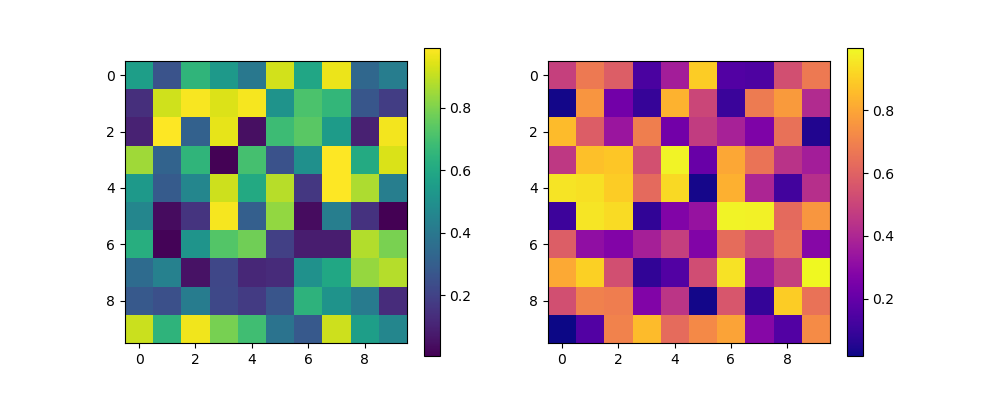

In [93]:
import matplotlib.pyplot as plt
import numpy as np
import ipywidgets as widgets
from IPython.display import display

# 1. Initialize the Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
im1 = ax1.imshow(np.random.rand(10, 10), cmap='viridis')
im2 = ax2.imshow(np.random.rand(10, 10), cmap='plasma')

cbar1 = fig.colorbar(im1, ax=ax1)
cbar2 = fig.colorbar(im2, ax=ax2)

# 2. Define the Update Function
def update_plots(change):
    if change['type'] == 'change' and change['name'] == 'value':
        value = change['new']
        new_data1 = np.random.rand(10, 10) * value
        new_data2 = np.random.rand(10, 10) * (10 - value)

        im1.set_array(new_data1)
        im2.set_array(new_data2)

        # Update colorbar limits and potentially ticks
        im1.set_clim(new_data1.min(), new_data1.max())
        im2.set_clim(new_data2.min(), new_data2.max())

        cbar1.update_normal(im1) # Update colorbar based on new mappable
        cbar2.update_normal(im2)

        # Example: Customizing colorbar ticks
        cbar1.ax.set_yticks([0, 0.5 * value, value])
        cbar1.ax.set_yticklabels(['Low', 'Mid', 'High'])

        fig.canvas.draw_idle()

# 3. Create and Link ipywidgets
slider = widgets.FloatSlider(min=1, max=10, step=0.1, description='Scale:')
display(slider)
slider.observe(update_plots, names='value')

32

In [6]:
_ = tiffread_utils.load_file("BlueTopo_US5NH1AH_20220505.tiff", '../../seafloor_files')


              Tracing: load_file():
              args: ('BlueTopo_US5NH1AH_20220505.tiff', '../../seafloor_files')
              kwargs: {}
              output: {'depth': array([[1.e+06, 1.e+06, 1.e+06, ..., 1.e+06, 1.e+06, 1.e+06],
       [1.e+06, 1.e+06, 1.e+06, ..., 1.e+06, 1.e+06, 1.e+06],
       [1.e+06, 1.e+06, 1.e+06, ..., 1.e+06, 1.e+06, 1.e+06],
       ...,
       [1.e+06, 1.e+06, 1.e+06, ..., 1.e+06, 1.e+06, 1.e+06],
       [1.e+06, 1.e+06, 1.e+06, ..., 1.e+06, 1.e+06, 1.e+06],
       [1.e+06, 1.e+06, 1.e+06, ..., 1.e+06, 1.e+06, 1.e+06]],
      shape=(2126, 1584), dtype=float32), 'ndv': 1000000.0, 'resolution': 4.0, 'dimensions': (2126, 1584)}
              output_len: 4


In [7]:
bool(None)

False

In [2]:
test_surface = tiffread_utils.load_file('sample_tiff.tif', 'tests', verbose=False)
test_depth = test_surface['depth']
test_resolution = test_surface['resolution']
test_indices = fft_funcs.get_column_indices(test_depth.shape[1], resolution=test_resolution, linespacing_meters=500, max_multiple=4)


        Tracing: get_column_indices():
        args: (1249,)
        kwargs: {'resolution': 8.0, 'linespacing_meters': 500, 'max_multiple': 4}
        output: [  93  156  219  282  345  408  471  534  597  660  723  786  849  912
  975 1038 1101]
        output_len: 17
              
